In [ ]:
# Imports 
import torch
from PIL import Image 
from torchvision import transforms
import torchvision
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score as sk_accuracy
from torch.utils.data import Dataset
from torchvision import transforms
import glob 
import os 
from torch.utils.data import DataLoader 
from torch import nn
import numpy as np
from torch.nn import functional as F
from torchvision.models.segmentation import deeplabv3_resnet50 
import numpy as np
import sklearn
import matplotlib.pyplot as plt


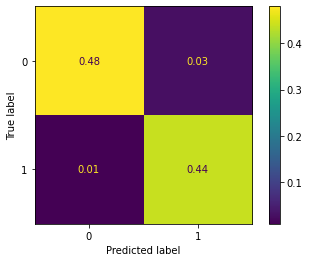

In [ ]:
  confusion_matrix = np.array([[0.48, 0.03], [0.01, 0.44]])
  cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
  cm_display.plot()
  plt.show()

In [ ]:
# TODO: Save in drive? 
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Expert.zip
!unzip Expert.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Radiographs.zip
!unzip Radiographs.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Student.zip
!unzip Student.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Segmentation.zip
!unzip Segmentation.zip

In [ ]:
# Uncomment to use gpu
torch.cuda.set_device('cuda:0')

## Dataset

In [ ]:
img_size = (290, 420)
crop_size = (280, 400)

In [ ]:
img_size = (290, 420)
crop_size = (280, 400)
import json 
import torch
from PIL import Image 
from torchvision import transforms
import torchvision
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score as sk_accuracy
from torch.utils.data import Dataset
from torchvision import transforms
import glob 
import os 
from torch.utils.data import DataLoader 
from torch import nn
from torch.nn import functional as F
from torchvision.models.segmentation import deeplabv3_resnet50 
from torchvision.transforms import RandomCrop
from torchvision.transforms.functional import crop, hflip
import json
import random

radiograph_transforms = transforms.Compose([                                     
  #  transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.5)),
  #  transforms.RandomAdjustSharpness(sharpness_factor=1.1, p=0.5),
  #  transforms.RandomAutocontrast(p=0.5),
  #transforms.ColorJitter(contrast = 0.01)
  transforms.Lambda(lambda x: x)
   # transforms.RandomCrop((220, 360))
   ]
)

common_transforms = transforms.Compose((
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomCrop(240, 380)
))


# Create Dataset to easily load data from files. 
# Radiograph transforms -- extra transforms to apply to radiograph tensor
# mask_transform -- extra transforms to apply to mask tensor 
class MaskDataset(Dataset):
  def __init__(self, radiograph_transform = radiograph_transforms, common_transforms = common_transforms, path = ''):
    self.base_transform = transforms.Compose((
      transforms.ToTensor(),
      transforms.Resize(img_size)
    ))
    self.radiograph_transform = radiograph_transform
    self.common_transforms = common_transforms

    
    self.path = path
    files = glob.glob(self.path + 'Radiographs/*')
    self.files = [(x.split('/')[1]).lower() for x in files]

    with open(self.path + 'Expert/expert.json', 'r') as f:
      metadata = json.load(f)
    self.metadata = {}
    for img_metadata in metadata:
      # Make it easy to query by ID 
      key = img_metadata['External ID']
      self.metadata[key] = img_metadata
      # Add tag if it has abnormality or not 
      objects = img_metadata['Label']['objects']
      # TODO: Remove if we want objects 
      del img_metadata['Label']
      self.metadata[key]['abnormality_exists'] = not (len(objects) == 1 and objects[0]['title'] == "None")

  def _to_deeplab(self, mask):
    mask = self.base_transform(mask)[0].to(torch.int64)
    return torch.nn.functional.one_hot(mask, num_classes = 2).permute((2, 0, 1)).float()

  def __getitem__(self, idx):
    radiograph = Image.open(self.path + 'Radiographs/' + self.files[idx].upper())
    teeth_mask = Image.open(self.path + 'Segmentation/teeth_mask/' + self.files[idx].lower())
    abnormality_mask = Image.open(self.path + 'Expert/mask/' + self.files[idx].upper())
    gaze_map = Image.open(self.path + 'Expert/gaze_map/gray/' + self.files[idx].upper())

    # 3, H, W 
    radiograph = self.radiograph_transform(self.base_transform(radiograph))

    # Format deeplab expects
    # All mask channels are the same
    # 2, H, W
    teeth_mask = self._to_deeplab(teeth_mask)
    abnormality_mask = self._to_deeplab(abnormality_mask)
    gaze_map = self.radiograph_transform(self.base_transform(gaze_map))

    # print(teeth_mask.shape)
    # print(abnormality_mask.shape)
    # print(radiograph.shape)
    i, j, h, w = RandomCrop.get_params(radiograph, crop_size)
    radiograph = crop(radiograph, i, j, h, w)
    teeth_mask = crop(teeth_mask, i, j, h, w)
    abnormality_mask = crop(abnormality_mask, i, j, h, w)
    gaze_map = crop(gaze_map, i, j, h, w)
    if random.uniform(0, 1) > 0.5:
        radiograph = hflip(radiograph)
        teeth_mask = hflip(teeth_mask)
        abnormality_mask = hflip(abnormality_mask)
        gaze_map = hflip(gaze_map)
    # print(teeth_mask.shape)
    # print(abnormality_mask.shape)
    # print(radiograph.shape)

    img_metadata = self.metadata[self.files[idx].upper()]
    label = torch.tensor(img_metadata['abnormality_exists']).to(torch.int64)
    label = torch.nn.functional.one_hot(label, num_classes = 2)

    # NOTE: These both have three channels, but all channels have same value (greyscale)
    return {'radiograph' : radiograph, 'teeth_mask' : teeth_mask,
            'abnormality_mask': abnormality_mask,
            'metadata' : img_metadata,
            'gaze_map' : gaze_map,
            'label': label}
    
  
  def __len__(self):
    return len(self.files)

In [ ]:

# Data augmentation for radiographs
# Gaussian smoothing, random adjust sharpness and random autocontrast
radiograph_transforms = transforms.Compose([
   transforms.Resize(img_size),                                      
  #  transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.5)),
  #  transforms.RandomAdjustSharpness(sharpness_factor=1.1, p=0.5),
  #  transforms.RandomAutocontrast(p=0.5),
  # transforms.RandomHorizontalFlip(p=0.5),
   # transforms.RandomCrop((220, 360))
   ]
)


In [ ]:
dataset = MaskDataset(radiograph_transform=radiograph_transforms)

In [ ]:
dataset[0]

In [ ]:
from torch.utils.data import random_split

splits = [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
train_dataset, val_dataset = random_split(dataset, splits)


In [ ]:
count = 0
for i in range(0, 1000):
  if dataset[i]['label']:
    count += 1
count 

## Training

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

## Multi-Headed

In [ ]:
from sklearn.utils.extmath import fast_logdet
class MultiHeadedModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.resnet1 = torchvision.models.resnet18(pretrained = True).cuda()
    self.resnet1.fc = torch.nn.Identity() 

    self.resnet2 = torchvision.models.resnet18(pretrained = True).cuda()
   # print(self.resnet1.layers)
    self.resnet1.layer1.requires_grad = False
    self.resnet1.layer2.requires_grad = False
    self.resnet1.layer3.requires_grad = False
    #self.resnet1.layer4.requires_grad = False
    self.resnet2.fc = torch.nn.Identity()
    #self.resnet2.layer1.requires_grad = False
    #self.resnet2.layer2.requires_grad = False
    #self.resnet2.layer3.requires_grad = False
    #self.resnet2.layer4.requires_grad = False
    self.linear1 = nn.Linear(1024, 256)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(256, 2)
  def forward(self, batch):
    x1 = self.resnet1(batch['radiograph'].cuda())
    x2 = self.resnet2(batch['gaze_map'].cuda())
    x = torch.cat((x1, x2), dim = 1)
    x = self.relu1(self.linear1(x))
    x = self.linear2(x)
    return {'classification': x}
  

In [ ]:
MultiHeadedModel()

In [ ]:
import sklearn

def classifier_evaluation_metrics(val_dataloader, model):
  """ Expects input in N x CL x H x W, CL is number of classes"""
 
  total_accuracy = 0
  total_samples = 0
  total_f1 = 0
  confusion_matrix = np.zeros((2, 2))
  for batch in val_dataloader:
    radiograph = batch['radiograph'].cuda()
    num_samples = radiograph.shape[0]
    label = batch['label'][1].detach().cpu().numpy()
    predicted_label = (model(batch)['classification'][1] > 0.5).float().squeeze(0).detach().cpu().numpy()


    accuracy = sk_accuracy(label, predicted_label)
    cm = sklearn.metrics.confusion_matrix(label, predicted_label, normalize = 'all')
    confusion_matrix += cm * num_samples
    f1 = sklearn.metrics.f1_score(label, predicted_label)

    total_accuracy += num_samples * accuracy
    total_samples += num_samples
    total_f1 += num_samples * f1
    del radiograph

  confusion_matrix = confusion_matrix / total_samples 
  cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
  cm_display.plot()
  plt.show()
  accuracy = total_accuracy / total_samples 
  total_f1 /= total_samples
  print("ACCURACY", accuracy, "F1", total_f1)




In [ ]:


""" Helper function to train  amodel with given hyperparameters """
def training_loop(train_dataset, val_dataset, model, optim = None, num_epochs = 7, lr=3e-4, reg=1e-5, batch_size=2, print_every = 50):
  losses = []
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
  size = int(0.15 * len(train_dataset))
  train_subset, _ = random_split(train_dataset, [size, len(train_dataset) - size])
  train_subset_dl = DataLoader(train_subset, batch_size = batch_size, shuffle = False)

  class_loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([2, 1]).cuda())

  # Configure optimizer 
  if optim == None:
    optim = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = reg)

  for i in range(num_epochs):
    print("EPOCH", i)

    total_loss = 0
    total_imgs = 0
    total_batches = 0
    

    for batch in train_dataloader:
      # Data
      radiograph = batch['radiograph'].cuda()
      mask = batch['gaze_map'].cuda()
      label = batch['label'].float().cuda()

      optim.zero_grad() # Zero gradient 
      
      # Run model
      y_hat = model(batch)
      #y_hat_mask = y_hat['out']
      y_hat_abnormality = y_hat['classification']

      # Compute loss 
      # loss1 = segmentation_loss_fn(y_hat_mask, mask.float())
      loss = class_loss_fn(y_hat_abnormality, label)
      #loss = loss1 + loss2
      
      # Backpropogate loss
      loss.backward()

      # Update gradients 
      optim.step()

      # Random Bookkeeping 
      total_loss += loss.data * radiograph.shape[0]
      total_imgs += radiograph.shape[0]
      total_batches += 1

      if total_batches % print_every == 0:
        print('Loss', (total_loss / total_imgs).item())
      losses.append((total_loss / total_imgs).item())
    # Run validation 
    print("VAL")
    classifier_evaluation_metrics(val_dataloader, model)
    print("TEST")
    classifier_evaluation_metrics(train_subset_dl, model)
  return losses

EPOCH 0
Loss 0.8318153023719788
Loss 0.8184493780136108
Loss 0.7912992835044861
Loss 0.8031056523323059
Loss 0.804545521736145
Loss 0.8014851212501526
Loss 0.8015888333320618
Loss 0.7751612067222595
VAL


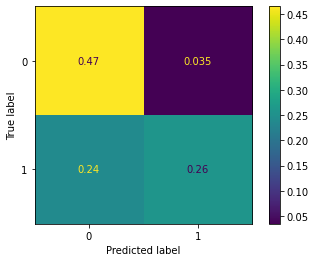

ACCURACY 0.725 F1 0.52
TEST


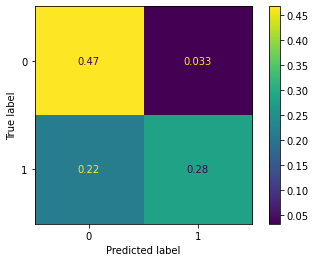

ACCURACY 0.75 F1 0.5666666666666667
EPOCH 1
Loss 0.664721667766571
Loss 0.6372127532958984
Loss 0.6813693046569824
Loss 0.6850948929786682
Loss 0.6963370442390442
Loss 0.6850666999816895
Loss 0.6741293668746948
Loss 0.6804777383804321
VAL


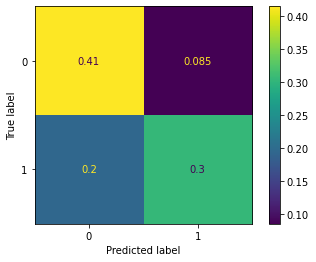

ACCURACY 0.72 F1 0.61
TEST


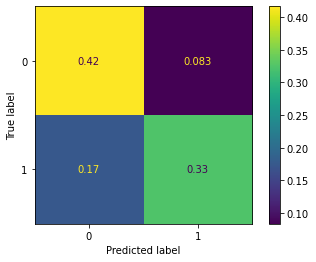

ACCURACY 0.7416666666666667 F1 0.65
EPOCH 2
Loss 0.7160373330116272
Loss 0.657072126865387
Loss 0.6393454074859619
Loss 0.6098473072052002
Loss 0.6072582006454468
Loss 0.6163780093193054
Loss 0.6301454305648804
Loss 0.6240100860595703
VAL


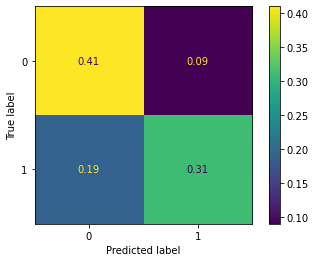

ACCURACY 0.72 F1 0.62
TEST


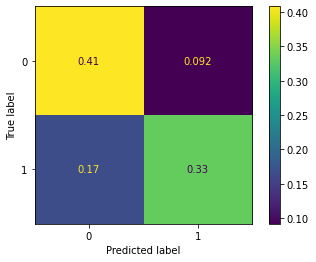

ACCURACY 0.7416666666666667 F1 0.6666666666666666
EPOCH 3
Loss 0.6601184010505676
Loss 0.5211362838745117
Loss 0.6041518449783325
Loss 0.5876731872558594
Loss 0.6003328561782837
Loss 0.6058074831962585
Loss 0.5895016193389893
Loss 0.5820062160491943
VAL


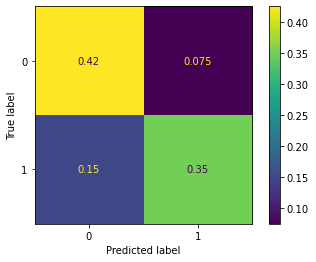

ACCURACY 0.775 F1 0.7
TEST


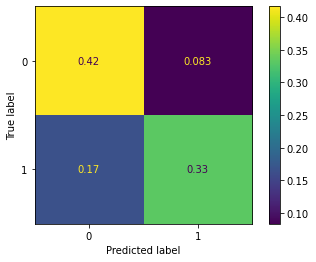

ACCURACY 0.75 F1 0.6666666666666666
EPOCH 4
Loss 0.4989079535007477
Loss 0.5293513536453247
Loss 0.5280051827430725
Loss 0.5149109363555908
Loss 0.531581461429596
Loss 0.5202230215072632
Loss 0.5342822074890137
Loss 0.5380925536155701
VAL


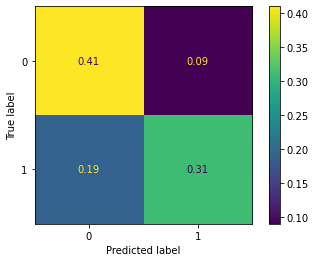

ACCURACY 0.72 F1 0.62
TEST


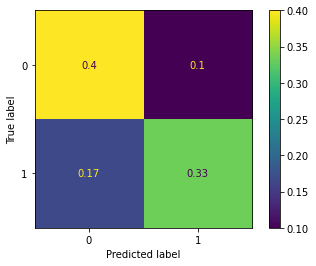

ACCURACY 0.7333333333333333 F1 0.6666666666666666
EPOCH 5
Loss 0.41277727484703064
Loss 0.49514979124069214
Loss 0.5390007495880127
Loss 0.5638756155967712
Loss 0.5545456409454346
Loss 0.5589861273765564
Loss 0.5627106428146362
Loss 0.5485262870788574
VAL


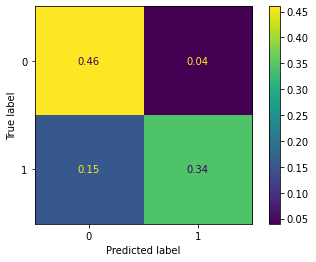

ACCURACY 0.805 F1 0.69
TEST


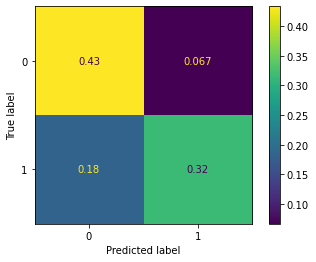

ACCURACY 0.75 F1 0.6333333333333333
EPOCH 6
Loss 0.5760878920555115
Loss 0.5523815751075745
Loss 0.5110545754432678
Loss 0.5226991772651672
Loss 0.5087745785713196
Loss 0.5079619288444519
Loss 0.5203281044960022
Loss 0.526012122631073
VAL


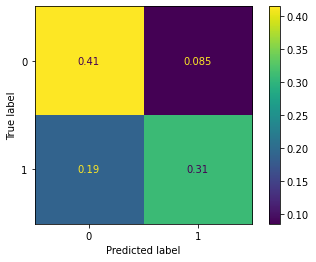

ACCURACY 0.725 F1 0.62
TEST


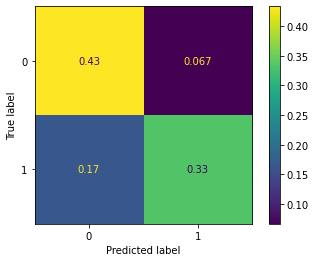

ACCURACY 0.7666666666666667 F1 0.6666666666666666


In [ ]:
model = MultiHeadedModel().cuda()
losses = training_loop(train_dataset, val_dataset, model)

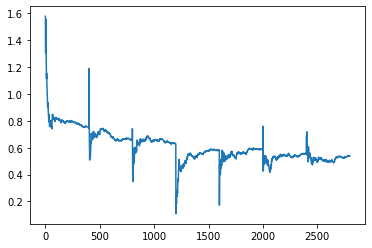

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
print((dataset[0]['radiograph'][0] - dataset[0]['radiograph'][0]).max())


tensor(0.9794)


In [ ]:
# Visualize predictions
to_pil = torchvision.transforms.ToPILImage()
def display_mask(mask):
  mask = (mask > 0.5).float()
  return to_pil(mask[1].unsqueeze(0))

In [ ]:
# Display predicted result for first radiograph
model.eval()
mask = model(dataset[300]['radiograph'].unsqueeze(0).cuda())['out']
display_mask(mask.squeeze())

In [ ]:
# Display ground truth
import random
idx = random.randrange(0, 1000)
print(idx)
display_mask(dataset[300]['teeth_mask'])

```teeth_bbox.json```: Contains bounding box and label for each tooth. \\
```teeth_polygon.json```: Contains bounding box, label, and list of polygons for each point. 
```Segmentation/teeth_mask```: Contains a mask for where teeth are. Teeth aren't labeled though. 
